In [60]:

# Load the necessary packages.# Load  

import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from PIL import Image
import progressbar
to_pil=ToPILImage()
%matplotlib inline

In [61]:
# Helper functions.

def load_image(path):
    image = Image.open(path) #convert LA is greyscale
    plt.imshow(image)
    plt.title("Image loaded successfully")
    plt.axis("off")
    return image

def preprocess_image(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Scale(256),transforms.CenterCrop(224),
 
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze_(0), requires_grad=True)
    return image

In [62]:
# Download and load the pretrained vgg16 model.

vgg16=models.vgg16(pretrained=True)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [63]:

# Modify the model to stop at a desired layer.# Modif 

class submodel(nn.Module): 
            def __init__(self,model,last_layer):
                super(submodel,self).__init__()
                self.features = nn.Sequential(
                    # stop at a desired layer.
                    *list(model.features.children())[:last_layer]
                )
            def forward(self, x):
                x = self.features(x)
                return x

In [64]:
# ReLU backward hook.

def relu_backward_deconv_hook(module,grad_in,grad_out):
     if isinstance(module, nn.ReLU):
        return (torch.clamp(grad_out[0], min=0.0),)
def Deconvolution(model):
    for m in model.modules():
        if isinstance(m,nn.ReLU):
            m.register_backward_hook(relu_backward_deconv_hook)

In [57]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        #self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
        #self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
        #self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1)
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.conv3_drop = nn.Dropout2d(p = 0.1)
      
        #assumes a batch size of 50
        #self.fc1 = nn.Linear(31360,64).cuda()
        #self.fc2 = nn.Linear(64, 25).cuda()
        #self.fc3 = nn.Linear(25,2).cuda()
        self.fc1 = nn.Linear(31360,64)
        self.fc2 = nn.Linear(64, 25)
        self.fc3 = nn.Linear(25,2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [58]:
# Deconvolution of image given the layer and number of filters to visualize.

def deconvolution(image,last_layer=1,num_filters=64):
    
    # Get the submodel
    vgg16_submodel=submodel(vgg16,last_layer)

    jq_m = Net1()
    #jq_m = jq_m.load_state_dict(torch.load('/Users/silver/Desktop/net1_weight100ep.pt'))
    #someLayer = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Deconvolution(vgg16_submodel)
    
    #Forward pass.
    output=vgg16_submodel(image)

    #Zero out the existing gradient buffers.
    vgg16_submodel.zero_grad()

    gradients=[]
    bar=progressbar.ProgressBar(max_value=num_filters)

    for filter_index in range(num_filters):

        #Progress indicator
        bar.update(filter_index)

        #Calculate the loss.
        loss=torch.max(output[0][filter_index])

        #Backward Pass
        loss.backward(retain_graph=True)

        #Visualize the gradient image
        image.grad.data=image.grad.data-image.grad.data.min()
        image.grad.data/=(image.grad.data.max()-image.grad.data.min())
        grads=image.grad.data.squeeze(0)
        grads.transpose_(0,1) #don't use permute.
        grads.transpose_(1,2)
        gradients.append(grads)

    fig=plt.figure(figsize=(30,30),facecolor='black')    
    for i in range(int(np.sqrt(num_filters))*int(np.sqrt(num_filters))):
        a=fig.add_subplot(np.sqrt(num_filters),np.sqrt(num_filters), i+1)
        a.imshow(gradients[i])
        a.axis('off')
        plt.subplots_adjust(hspace=0.01,wspace=0.01,left=0.01,bottom=0.01)
   # plt.savefig('/Users/silver/Desktop/deconvs/Deconvolution.jpg',facecolor=fig.get_facecolor(),bbox_inches='tight')

/Users/silver/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
 98% (63 of 64) |####################### | Elapsed Time: 0:00:01 ETA:   0:00:00

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x114d40bf8> (for post_execute):


ValueError: Floating point image RGB values must be in the 0..1 range.

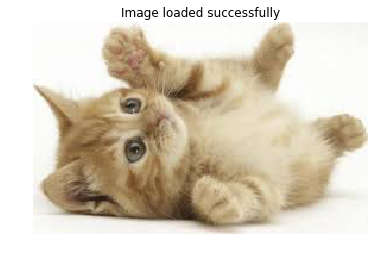

ValueError: Floating point image RGB values must be in the 0..1 range.

In [59]:
# Deconvolution visualization of a cat.

cat=load_image("/Users/silver/Desktop/pics/cat.jpg")
cat=preprocess_image(cat)
deconvolution(cat,1,64)